<a href="https://colab.research.google.com/github/codml/AI_jupyter/blob/main/chapter_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(3,), name='my_input')
features = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10, activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 my_input (InputLayer)       [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 64)                256       
                                                                 
 dense_1 (Dense)             (None, 10)                650       
                                                                 
Total params: 906 (3.54 KB)
Trainable params: 906 (3.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


40/40 [==============================] - 0s 6ms/step


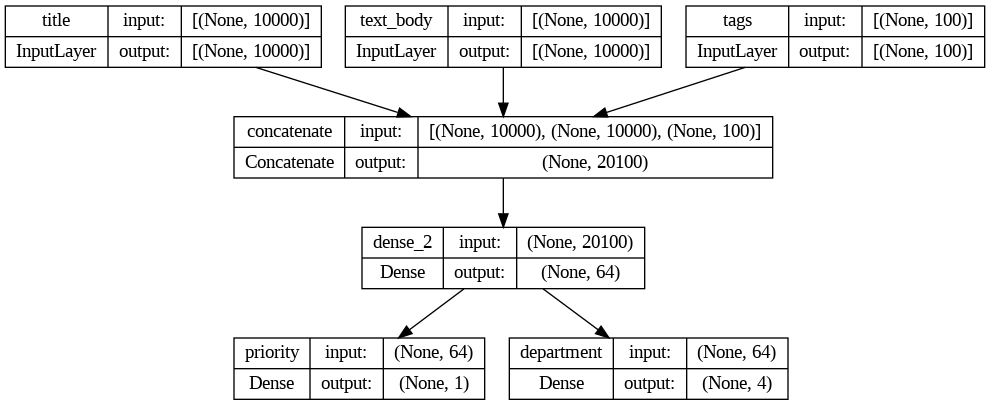

In [2]:
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name='title')
text_body = keras.Input(shape=(vocabulary_size,), name='text_body')
tags = keras.Input(shape=(num_tags,), name='tags')

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation='relu')(features)

priority = layers.Dense(1, activation='sigmoid', name='priority')(features)
department = layers.Dense(
    num_departments, activation='softmax', name='department')(features)

model = keras.Model(inputs=[title, text_body, tags],
                    outputs=[priority, department])

import numpy as np

num_samples = 1280

title_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
text_body_data = np.random.randint(0, 2, size=(num_samples, vocabulary_size))
tags_data = np.random.randint(0, 2, size=(num_samples,num_tags))

priority_data = np.random.random(size=(num_samples, 1))
department_data = np.random.randint(0, 2, size=(num_samples, num_departments))

model.compile(optimizer='rmsprop',
              loss=['mean_squared_error', 'categorical_crossentropy'])
model.fit([title_data, text_body_data, tags_data],
          [priority_data, department_data],
          epochs=1)
model.evaluate([title_data, text_body_data, tags_data],
               [priority_data, department_data])
priority_preds, department_preds = model.predict(
    [title_data, text_body_data, tags_data]
) # dictionary도 가능!!
keras.utils.plot_model(model, 'ticket_classifier.png', show_shapes=True)

In [3]:
model.layers

In [4]:
model.layers[3].input

[<KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'title')>,
 <KerasTensor: shape=(None, 10000) dtype=float32 (created by layer 'text_body')>,
 <KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'tags')>]

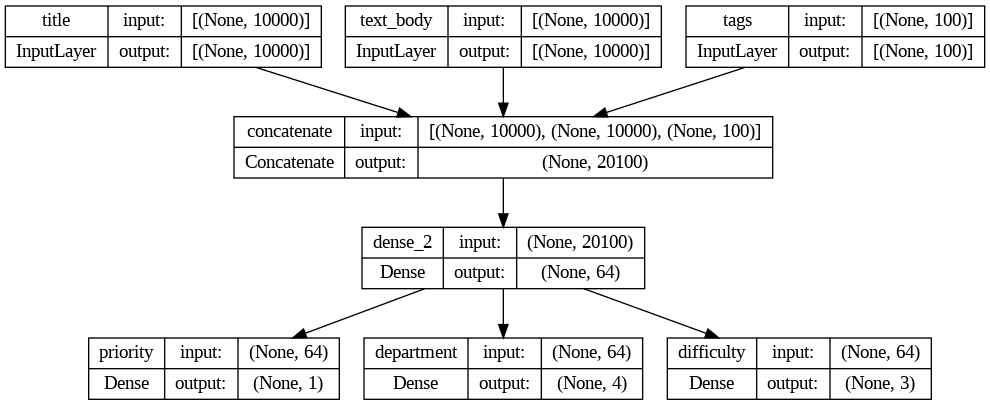

In [5]:
features = model.layers[4].output
difficulty = layers.Dense(3, activation='softmax', name='difficulty')(features)
new_model = keras.Model(
    inputs=[title, text_body, tags],
    outputs=[priority, department, difficulty]
)
keras.utils.plot_model(
    new_model, 'updated_ticket_classifier.png', show_shapes=True
)

In [6]:
class CustomerTicketModel(keras.Model):
    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation='relu')
        self.priority_scorer = layers.Dense(1, activation='sigmoid')
        self.department_classifier = layers.Dense(
            num_departments, activation='softmax'
        )

    def call(self, inputs):
        title = inputs['title']
        text_body = inputs['text_body']
        tags = inputs['tags']
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

model = CustomerTicketModel(num_departments=4)
priority, department = model(
    {'title': title_data, 'text_body': text_body_data, 'tags': tags_data}
)

model.compile(optimizer='rmsprop',
              loss=['mean_squared_error', 'categorical_crossentropy'],
              metrics=[['mean_absolute_error'], ['accuracy']])
model.fit({"title": title_data,
          "text_body": text_body_data,
          "tags": tags_data},
          [priority_data, department_data],
          epochs=1)
model.evaluate({'title': title_data,
                'text_body': text_body_data,
                'tags': tags_data},
               [priority_data, department_data])
priority_preds, department_preds = model.predict({'title': title_data,
                                                  'text_body': text_body_data,
                                                  'tags': tags_data})

40/40 [==============================] - 0s 8ms/step


In [10]:
from tensorflow.keras.datasets import mnist

def get_mnist_model():
    inputs = keras.Input(shape=(28 * 28,))
    features = layers.Dense(512, activation='relu')(inputs)
    features = layers.Dropout(0.5)(features)
    outputs = layers.Dense(10, activation='softmax')(features)
    model = keras.Model(inputs, outputs)
    return model

(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype('float32') / 255
test_images = test_images.reshape((10000, 28 * 28)).astype('float32') / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]

import tensorflow as tf

class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name='rmse', **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name='mse_sum', initializer='zeros')
        self.total_samples = self.add_weight(
            name='total_samples', initializer='zeros', dtype='int32')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)

    def result(self):
        return tf.sqrt(self.mse_sum / tf.cast(self.total_samples, tf.float32))

    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy', RootMeanSquaredError()])
model.fit(train_images, train_labels,
          epochs=3,
          validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 [==============================] - 7s 4ms/step - loss: 0.2946 - accuracy: 0.9123 - rmse: 7.1776 - val_loss: 0.1590 - val_accuracy: 0.9538 - val_rmse: 7.3502
Epoch 2/3
1563/1563 [==============================] - 5s 4ms/step - loss: 0.1614 - accuracy: 0.9537 - rmse: 7.3513 - val_loss: 0.1173 - val_accuracy: 0.9681 - val_rmse: 7.4059
Epoch 3/3
313/313 [==============================] - 1s 2ms/step - loss: 0.0977 - accuracy: 0.9712 - rmse: 7.4322


In [14]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
        monitor='val_accuracy',
        patience=2,
    ),
    keras.callbacks.ModelCheckpoint(
        filepath='checkpoint_path.keras',
        monitor='val_loss',
        save_best_only=True,
    )
]

model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
          epochs=30,
          callbacks=callbacks_list,
          validation_data=(val_images, val_labels))

Epoch 1/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2936 - accuracy: 0.9121 - val_loss: 0.1475 - val_accuracy: 0.9582
Epoch 2/30
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1606 - accuracy: 0.9538 - val_loss: 0.1197 - val_accuracy: 0.9658
Epoch 3/30
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1297 - accuracy: 0.9638 - val_loss: 0.1051 - val_accuracy: 0.9703
Epoch 4/30
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1145 - accuracy: 0.9692 - val_loss: 0.1010 - val_accuracy: 0.9744
Epoch 5/30
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1029 - accuracy: 0.9718 - val_loss: 0.0989 - val_accuracy: 0.9755
Epoch 6/30
1563/1563 [==============================] - 5s 4ms/step - loss: 0.0921 - accuracy: 0.9751 - val_loss: 0.0968 - val_accuracy: 0.9766
Epoch 7/30
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0861 - accuracy: 0.9767 - val_loss: 0.0944 - val_accuracy:

Epoch 1/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.2912 - accuracy: 0.9147 - val_loss: 0.1446 - val_accuracy: 0.9585
Epoch 2/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1576 - accuracy: 0.9539 - val_loss: 0.1158 - val_accuracy: 0.9672
Epoch 3/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1299 - accuracy: 0.9634 - val_loss: 0.0956 - val_accuracy: 0.9743
Epoch 4/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.1142 - accuracy: 0.9689 - val_loss: 0.1025 - val_accuracy: 0.9752
Epoch 5/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.1014 - accuracy: 0.9722 - val_loss: 0.0983 - val_accuracy: 0.9770
Epoch 6/10
1563/1563 [==============================] - 5s 3ms/step - loss: 0.0951 - accuracy: 0.9743 - val_loss: 0.0931 - val_accuracy: 0.9775
Epoch 7/10
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0860 - accuracy: 0.9760 - val_loss: 0.0892 - val_accuracy:

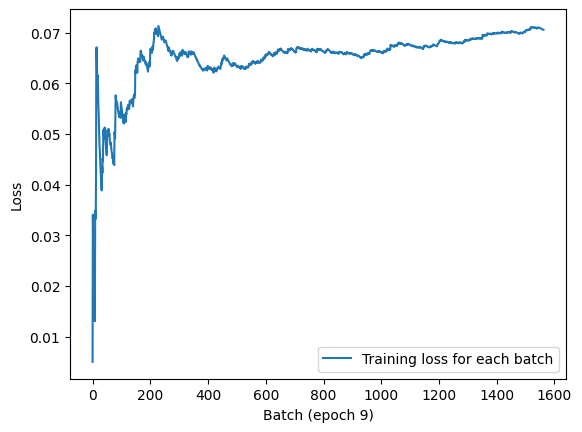

In [15]:
from matplotlib import pyplot as plt

class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []
    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))
    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
                 label='Training loss for each batch')
        plt.xlabel(f'Batch (epoch {epoch})')
        plt.ylabel('Loss')
        plt.legend()
        plt.savefig(f'plot_at_epoch_{epoch}')
        self.per_batch_losses = []

model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.fit(train_images, train_labels,
          epochs=10,
          callbacks=[LossHistory()],
          validation_data=(val_images, val_labels))